# Spatial Analyses: vulnerability to lead poisoing and exposure.

## Introduction
In this exercise, we perform common spatial queries and vector processing on census data at the block group and census track levels. The overall goal is to explore the distribution of metals and its association with various population groups. As a geospatial analyst and EPA consultant for the city of Syracuse, your task is to investigate the relationship between metal concentration (in particular lead) and population. In particular, research suggests higher concentration of metals in minorities. In addition, children are more at risk of lead poisoning. 

## Documentation and packages

First, we set up the code by providing information on the Authors, Creation dates, version by importing relevant python packages. Documenting and providing context and information within a script is important as it is often the case that code will be reused for other applications or other users/colleagues Good documentation improves code reproducibility as well.

In [75]:
####################################    Spatial Analyses: SYRACUSE   #######################################
#######################################  Analyse data from Census #######################################
#This script performs basic analyses for the Exercise 1 of the workshop using Census data.
# The overall goal is to explore spatial autocorrelation and aggregation of units of analyses.     
#
#AUTHORS: Benoit Parmentier                                             
#DATE CREATED: 12/29/2018 
#DATE MODIFIED: 03/29/2019
#Version: 1
#PROJECT: AAG 2019 workshop preparation
#TO DO:
#
#COMMIT: added Moran'I and spatial regression, AAG workshop
#Useful links:
#sudo mount -t vboxsf C_DRIVE ~/c_drive

##################################################################################################

###### Library used in this script

import gdal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import descartes
import libpysal as lp #new pysal interface
from cartopy import crs as ccrs
from pyproj import Proj
from osgeo import osr
from shapely.geometry import Point
import pysal as ps
from shapely.geometry import shape
import fiona


The list of packages above constains some of the most common packages used in geospatial data processing, wrangling and analyses. Notables spatial packages are "geopandas", "rasterio", "pysal", "gdal" and "shapely". Geopandas extends the "pandas" package to allow for the use of spatial data using a geometry column in a DataFrame object. It implements a version of the OGC Simple Feature model (https://www.opengeospatial.org/standards/sfa) using the "shapely" package to define the geometry of spatial objects. GDAL and Rasterio allow raster layers operations and processing including reprojection, distance compuation, mosaicing. The "pysal" package provides spatial analyses tools such as Moran's I and spatial regression modeling. In this exercise, we also use pysal for the OLS regression and to check for indepence in the residuals.

## Functions

In the next part of the script, we declare all the functions used in the sripts. The first function builds an output directory. It is good practice to place functions at the beginning of a script or an external source file.

In [76]:

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")


## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [77]:
############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
#in_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/Exercise_1/data"
#in_dir="/nfs/bparmentier-data/Data/workshop_spatial/Exercise_1/data/Oregon_covariates"
in_dir = "/nfs/bparmentier-data/Data/workshop_spatial/sesync2019_geospatial_workshop/AAG2019_Geospatial_Analysis_and_Data_Science_python_workshop/syracuse_lead_analyses/data"

#Z:\Data\workshop_spatial\sesync2019_geospatial_workshop\AAG2019_Geospatial_Analysis_and_Data_Science_python_workshop\syracuse_lead_analyses\data
#ARGS 2
#out_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/Exercise_1/outputs"
out_dir = "/nfs/bparmentier-data/Data/workshop_spatial/sesync2019_geospatial_workshop/AAG2019_Geospatial_Analysis_and_Data_Science_python_workshop/syracuse_lead_analyses/outputs"

#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 7
out_suffix = "exercise1_03042019" #output suffix for the files and ouptut folder
#ARGS 8
NA_value = -9999 # number of cores
file_format = ".tif"

ct_2000_fname = "ct_00.shp" # CT_00: Cencus Tracts 2000
bg_2000_fname = "bg_00.shp" # BG_00: Census Blockgroups 2000
bk_2000_fname = "bk_00.shp" # BK_00: Census Blocks 2000

census_table_fname = "census.csv" #contains data from census to be linked
soil_PB_table_fname = "Soil_PB.csv" #same as census table
tgr_shp_fname = "tgr36067lkA.shp" #contains data from census to be linked

metals_table_fname = "SYR_metals.xlsx" #contains metals data to be linked


## Input and output directories

Before any analyses, we start the script by creating a new output directory to store new files generated througout the script. Separating inputs from outputs avoids overwriting or modifiying the input source files. It is likely that you will repeath the analyses multiples times and generating a new output directory with a date or version can also help in tracking modeling and analyses outputs with different input arguments. 

In [78]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier

directory already exists


## PART I: Reading visualizing data

Part I consists in reading in census tracks, blocks and block groups from spatial files (shapefiles here) in geopandas DataFrame. The geopandas "read_file" can read many data types as it uses GDAL/OGR drivers to read inputs. We also read in textfile in the "csv" format and excel sheets using the "pandas" package. We explore the datasets by examining the coordinate systems, size (use "shape") and by displaying a few rows of the geopandas/pandas data frames.

(57, 19)

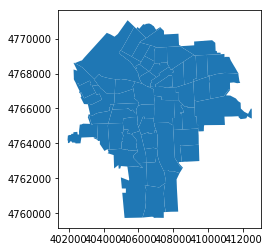

In [79]:
###########################################
### PART I: READ IN DATASETS #######

## Census tracks for Syracuse in 2000
ct_2000_filename = os.path.join(in_dir,ct_2000_fname)
## block groups for Syracuse in 2000
bg_2000_filename = os.path.join(in_dir,bg_2000_fname)
## block for Syracuse in 200
bk_2000_filename = os.path.join(in_dir,bk_2000_fname)

#Read spatial data 
ct_2000_gpd = gpd.read_file(ct_2000_filename)
bg_2000_gpd = gpd.read_file(bg_2000_filename)
bk_2000_gpd = gpd.read_file(bk_2000_filename)

#Explore datasets:
ct_2000_gpd.describe()
ct_2000_gpd.plot(column="CNTY_FIPS")
ct_2000_gpd.head()

#Read tabular data
metals_df = pd.read_excel(os.path.join(in_dir,metals_table_fname))
census_syr_df = pd.read_csv(os.path.join(in_dir,census_table_fname),sep=",",header=0) #census information
#This soil lead in UTM 18 coordinate system
soil_PB_df = pd.read_csv(os.path.join(in_dir,soil_PB_table_fname),sep=",",header=None) #point locations

#Check size
ct_2000_gpd.shape #57 spatial entities (census)
bg_2000_gpd.shape #147 spatial entities (block groups)
bk_2000_gpd.shape #2025 spatial entities (blocks)
census_syr_df.shape #147 spatial entities
metals_df.shape #57 entities


## PART 2: Summarize/aggregate poppulation at census track level

We would like to map population and exposure to lead in Syracuse at the censustrack level. This requires bringing attribute data from the census together with the blockgroup and census track information. We explore  also two ways of joining and aggregating data at census track level:
First method:
- First join census information data to blockgroups
- Summarize/aggregate poppulation at census track level ###
Second method:
#### Step 3: Plot population 2000 by tracks



Text(0.5, 1.0, 'POPULATION 2000')

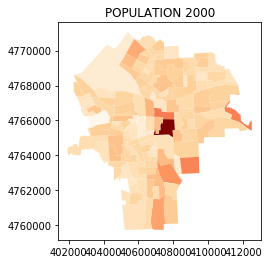

In [80]:
#########################################################
####### PART 2: Visualizing population in 2000 at Census track level with geopandas layers 
#### We explore  also two ways of joining and aggregating data at census track level #########
#### Step 1: First join census information data to blockgroups
#### Step 2: Summarize/aggregate poppulation at census track level ###
#### Step 3: Plot population 2000 by tracks

### Step 1: First join census data to blockgroups

bg_2000_gpd.columns # missing census information:check columns' name for the data frame
census_syr_df.columns #contains census variables to join
#Key is "TRACT" but with a different format/data type
#First fix the format
bg_2000_gpd.head()
bg_2000_gpd.shape
census_syr_df.BKG_KEY.head()
#ct_2000_gpd.TRACT.dtype
census_syr_df.dtypes #check all the data types for all the columns
bg_2000_gpd.BKG_KEY.dtypes #check data type for the "BKG_KEY"" note dtype is "O"
census_syr_df.BKG_KEY.dtypes # check data type, note that it is "int64"

#Change data type for BKG_KEY column from object 'O" to int64
bg_2000_gpd['BKG_KEY'] = bg_2000_gpd['BKG_KEY'].astype('int64')

# Join data based on common ID after matching data types
bg_2000_gpd = bg_2000_gpd.merge(census_syr_df, on='BKG_KEY')
# Check if data has been joined 
bg_2000_gpd.head()

#Quick visualization of population 
bg_2000_gpd.plot(column='POP2000',cmap="OrRd")
plt.title('POPULATION 2000')


## Method 1: Summarize by census track using DISSOLVE geospatial operation


In [81]:
#############
#### Step 2: Summarize/aggregate poppulation at census track level

### Method 1: Summarize by census track using DISSOLVE geospatial operation

#To keep geometry, we must use dissolve method from geopanda
census_2000_gpd = bg_2000_gpd.dissolve(by='TRACT',
                                       aggfunc='sum')
type(census_2000_gpd)
census_2000_gpd.index
#Note that the TRACT field has become the index
census_2000_gpd=census_2000_gpd.reset_index() # reset before comparing data
census_2000_gpd.shape #Dissolved results shows aggregation from 147 to 57.



(57, 44)

## Method 2: Summarize using groupby aggregation and joining

This method uses "groupby" to aggregation information by census track using a summary function. We use here "sum" to generate summary at the census track level. Note that the output of the gropuby operation is a pandas DataFrame. The output table is then join to the census track level geopanda DataFrame using the track ID as the primary key. Before joing the datasets, we must ensure that the datatypes of both keys match and change the column data type us "astype" if necessary. The join operation is carried out using the merge function. 


In [84]:
### Method 2: Summarize using groupby aggregation and joining

##Note losing TRACT field
census_2000_df = bg_2000_gpd.groupby('TRACT',as_index=False).sum()
type(census_2000_df) #This is a panda object, we lost the geometry after the groupby operation.
census_2000_df.shape #Groupby results shows aggregation from 147 to 57.

### Let's join the dataFrame to the geopanda object to the census track layer 
census_2000_df['TRACT'].dtype == ct_2000_gpd['TRACT'].dtype #Note that the data type for the common Key does not mach.  
census_2000_df['TRACT'].dtype # check data type field from table
ct_2000_gpd['TRACT'].dtype # check data type field from census geopanda layer
ct_2000_gpd['TRACT'] = ct_2000_gpd.TRACT.astype('int64') #Change data type to int64
ct_2000_gpd.shape #57 rows and 8 columns

ct_2000_gpd = ct_2000_gpd.merge(census_2000_df, on='TRACT')
print("Shape of census tracks geo DataFrame :", ct_2000_gpd.shape) #57 rows and 50 columns

ct_2000_gpd.head()

Shape of census tracks geo DataFrame : (57, 134)


,FIPS,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,Shape_Leng_x,Shape_Area_x,geometry,BKG_KEY_x,Shape_Leng_y,...,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,perc_hispa
0,36067000100,36,067,36067,100,13520.232628,6.135184e+06,"POLYGON ((403476.3667961732 4767681.659353677,...",360670001001,13520.232628,...,45,3,10,74,2.36,309,47,88,174,0.030534
1,36067000300,36,067,36067,300,3664.906267,5.528384e+05,"POLYGON ((407273.7082073092 4770615.348040303,...",721340006003,5225.175499,...,157,16,69,408,5.96,716,41,463,212,0.077622
2,36067000200,36,067,36067,200,4620.537302,1.084286e+06,"POLYGON ((405762.8405454708 4770677.466250783,...",721340004003,6038.106998,...,246,45,162,739,6.27,1627,210,582,835,0.075676
3,36067000400,36,067,36067,400,5931.046228,1.513148e+06,"POLYGON ((408398.5954386378 4769563.645143542,...",1442680016010,11971.493374,...,386,26,133,925,11.56,1650,99,1091,460,0.036988
4,36067001000,36,067,36067,1000,5668.226852,1.237272e+06,"POLYGON ((409917.2280338025 4769065.286384709,...",1442680040010,10786.395771,...,341,38,207,886,11.08,2232,159,688,1385,0.166031


## Plotting population at census track level in Syracuse

Text(0.5, 1.0, 'POP2000')

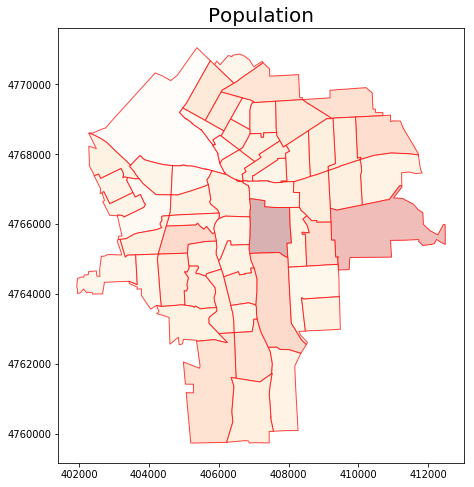

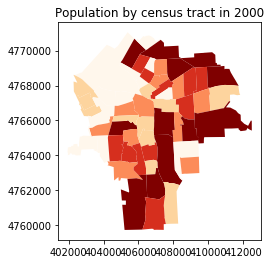

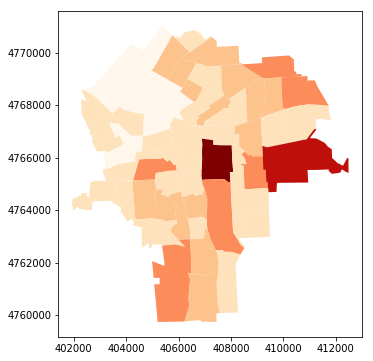

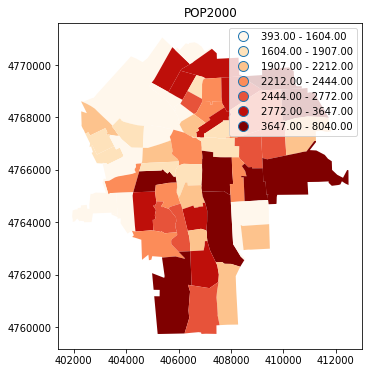

In [85]:
#### Step 3: Plot population 2000 by tracks in Syracuse

### Check if the new geometry of entities is the same as census
fig, ax = plt.subplots(figsize=(12,8))
ax.set_aspect('equal') # set aspect to equal, done automatically in *geopandas* plot but not in pyplot
census_2000_gpd.plot(ax=ax,column='POP2000',cmap='OrRd')
ct_2000_gpd.plot(ax=ax,color='white',edgecolor="red",alpha=0.7) # Check if outputs from two methods match
ax.set_title("Population", fontsize= 20)

#### Generate population maps with two different class intervals

title_str = "Population by census tract in 2000"
census_2000_gpd.plot(column='POP2000',cmap="OrRd",
                 scheme='quantiles')
plt.title(title_str)

### Let's use more option with matplotlib

fig, ax = plt.subplots(figsize=(14,6))
census_2000_gpd.plot(column='POP2000',cmap="OrRd",
                 scheme='equal_interval',k=7,
                 ax=ax,
                 legend=False)

fig, ax = plt.subplots(figsize=(14,6))
census_2000_gpd.plot(column='POP2000',cmap="OrRd",
                 scheme='quantiles',k=7,
                 ax=ax,
                 legend=True)
ax.set_title('POP2000')

#Problem with legend
#ax.legend(loc=3,
#          fontsize=25,
#          frameon=False)
#plt.show()
#https://nbviewer.jupyter.org/github/pysal/mapclassify/blob/master/notebooks/south.ipynb
#q10 = ps.Quantiles(tx.HR90,k=10)
#q10.bins

#f, ax = plt.subplots(1, figsize=(9, 9))
#tx.assign(cl=q10.yb).plot(column='cl', categorical=True, \
#        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
#        edgecolor='white', legend=True)
#ax.set_axis_off()
#plt.show()

##PART 3: SPATIAL QUERY #############

We generate a dataset with metals and lead information by census tracks.
### To do so we use the following steps:
##Step 1: Join metals to census tracks 
##Step 2: Generate geopanda from PB sample measurements 
##Step 3: Join lead (pb) measurements to census tracks
##Step 4: Find average lead by census track


,x,y,ID,ppm,Coordinates
0,408164.2892,4762321.061,0,3.890648,POINT (408164.2892 4762321.061000001)
1,405914.8759,4767394.274,1,4.899391,POINT (405914.8759 4767394.274)
2,405723.9622,4767705.893,2,4.434912,POINT (405723.9622 4767705.893)
3,406702.7734,4769200.832,3,5.285548,POINT (406702.7734 4769200.831999999)
4,405392.3004,4765598.492,4,5.295919,POINT (405392.3004 4765598.492)


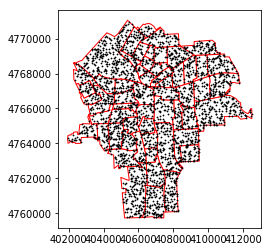

In [98]:
##### Step 1: Join metals to census tracks ###### 

metals_df.head()
metals_df.describe() # 57 rows  
##Number of rows suggests matching to the following spatial entities
metals_df.shape[0]== ct_2000_gpd.shape[0]
#Check data types before joining tables with "merge"
metals_df.dtypes
ct_2000_gpd.dtypes
ct_2000_gpd.shape
census_metals_gpd = ct_2000_gpd.merge(metals_df,left_on='TRACT',right_on='ID')
census_metals_gpd.shape #census information has been joined

##### Step 2: Generate geopanda from PB sample measurements ##### 
# Processing lead data to generate a geopanda object using shapely points

soil_PB_df.columns #Missing names for columns
soil_PB_df.columns = ["x","y","ID","ppm"]
soil_PB_df.head()

soil_PB_gpd = soil_PB_df.copy() # generate a new panda DataFrame object
type(soil_PB_gpd)
soil_PB_gpd['Coordinates']=list(zip(soil_PB_gpd.x,soil_PB_gpd.y)) #create a new column with tuples of coordinates
type(soil_PB_gpd)
soil_PB_gpd['Coordinates']= soil_PB_gpd.Coordinates.apply(Point) #create a point for each tupple row
type(soil_PB_gpd.Coordinates[0]) #This shows that we created a shapely geometry point
type(soil_PB_gpd) #This is still an panda DataFrame
soil_PB_gpd = gpd.GeoDataFrame(soil_PB_gpd,geometry='Coordinates') #Create a gpd by setting the geometry column
type(soil_PB_gpd) # This is now a GeoDataFrame

## Checking and setting the coordinates reference system
soil_PB_gpd.crs #No coordinate reference system (CRS) is set
census_metals_gpd.crs # Let's use the metal geopanda object to set the CRS

## Find out more about the CRS using the epsg code
epsg_code = census_metals_gpd.crs.get('init').split(':')[1]
inproj = osr.SpatialReference()
inproj.ImportFromEPSG(int(epsg_code))
inproj.ExportToProj4() # UTM 18: this is the coordinate system in Proj4 format
## Assign projection system
soil_PB_gpd.crs= census_metals_gpd.crs #No coordinate system is set
soil_PB_gpd.head()

## Now plot the points
fig, ax = plt.subplots()
census_metals_gpd.plot(ax=ax,color='white',edgecolor='red')
soil_PB_gpd.plot(ax=ax,marker='*',
                 color='black',
                 markersize=0.8)

soil_PB_gpd.head()

In [87]:
##### Step 3: Join lead (pb) measurements to census tracks #####
# Spatial query: associate points of pb measurements to each census tract

soil_PB_joined_gpd =gpd.tools.sjoin(soil_PB_gpd,census_2000_gpd,
                     how="left")
soil_PB_joined_gpd.columns
soil_PB_joined_gpd.shape #every point is associated with information from the census track it is contained in

len(soil_PB_joined_gpd.BKG_KEY.value_counts()) #associated BKG Key to points: 57 unique identifiers
len(soil_PB_joined_gpd.index_right.value_counts()) #associated BKG Key to points: 57 unique identifiers

#### Step 4: Find average lead by census track #####

grouped_PB_ct_df = soil_PB_joined_gpd[['ppm','TRACT','index_right']].groupby(['index_right']).mean() #compute average by census track
grouped_PB_ct_df = grouped_PB_ct_df.reset_index()
grouped_PB_ct_df.shape
grouped_PB_ct_df.head()

#grouped = grouped.rename(columns={'index_right': 'TRACT',
#                            'ppm': 'pb_ppm' })
grouped_PB_ct_df = grouped_PB_ct_df.rename(columns={'ppm': 'pb_ppm' })
type(grouped_PB_ct_df)

census_metals_gpd = census_metals_gpd.merge(grouped_PB_ct_df,on="TRACT")
census_metals_gpd.shape
census_metals_gpd.columns #check for duplicate columns

    
census_metals_df = pd.DataFrame(census_metals_gpd.drop(columns='geometry'))
outfile = "census_metals_pb_"+'_'+out_suffix+'.csv'

census_metals_df.to_csv(outfile)

outfile = "census_metals_pb_"+'_'+out_suffix+'.shp'
census_metals_gpd.to_file(os.path.join(out_dir,outfile))

census_metals_gpd.head()

,TRACT,FIPS,STATE_FIPS,CNTY_FIPS,STCOFIPS,Shape_Leng_x,Shape_Area_x,geometry,BKG_KEY,Shape_Leng_y,...,SRB,MZN,SZN,MPB,SPB,Tspbr,index_right_x,pb_ppm_x,index_right_y,pb_ppm_y
0,100,36067000100,36,067,36067,13520.232628,6.135184e+06,"POLYGON ((403476.3667961732 4767681.659353677,...",360670001001,13520.232628,...,9.29,482.55,819.77,187.54,141.07,4.949256,0,4.928121,0,4.928121
1,300,36067000300,36,067,36067,3664.906267,5.528384e+05,"POLYGON ((407273.7082073092 4770615.348040303,...",721340006003,5225.175499,...,9.66,239.04,117.44,190.25,125.28,4.830551,2,5.049756,2,5.049756
2,200,36067000200,36,067,36067,4620.537302,1.084286e+06,"POLYGON ((405762.8405454708 4770677.466250783,...",721340004003,6038.106998,...,8.36,419.25,428.99,492.36,798.56,6.682810,1,5.377026,1,5.377026
3,400,36067000400,36,067,36067,5931.046228,1.513148e+06,"POLYGON ((408398.5954386378 4769563.645143542,...",1442680016010,11971.493374,...,8.48,292.71,194.48,258.17,196.57,5.281019,3,4.756565,3,4.756565
4,1000,36067001000,36,067,36067,5668.226852,1.237272e+06,"POLYGON ((409917.2280338025 4769065.286384709,...",1442680040010,10786.395771,...,7.79,220.03,129.71,133.34,74.52,4.311068,9,4.690085,9,4.690085


## PART IV: Spatial regression: Vulnerability to metals #############
#Examine the relationship between metals, Pb and vulnerable populations in Syracuse
## Step 1: Explore Autocorrelation with Moran's I
## Step 2: Spatial regression: examine relationship between lead ppm and % hispanic

#### Step 1: Explore Autocorrelation with Moran's I #######


In [74]:
#################################################
##### PART IV: Spatial regression: Vulnerability to metals #############
#Examine the relationship between metals, Pb and vulnerable populations in Syracuse
## Step 1: Explore Autocorrelation with Moran's I
## Step 2: Spatial regression: examine relationship between lead ppm and % hispanic

#### Step 1: Explore Autocorrelation with Moran's I #######

census_metals_gpd.index
census_metals_gpd = census_metals_gpd.set_index('TRACT')

from libpysal.weights.contiguity import Queen

w = Queen.from_dataframe(census_metals_gpd)
type(w)
w.transform = 'r'
w.n # number of observations (spatial features)
w.neighbors # list of neighbours per census track
w.mean_neighbors

#http://pysal.org/notebooks/viz/splot/esda_morans_viz
import os
import splot

from esda.moran import Moran

#w = Queen.from_dataframe(gdf)
y = census_metals_gpd['pb_ppm'] 
y.shape
moran = Moran(y, w)
moran.I
moran.EI

from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()
moran.p_sim #observed moran's I statistically significant
y_lag = ps.lag_spatial(w,y) #this is a numpy array

census_metals_gpd['y'] = census_metals_gpd.pb_ppm
census_metals_gpd['y_lag'] = y_lag

sns.regplot(x=y,y=y_lag,data=census_metals_gpd)

# now plot neighbours links

### Step 2: Spatial regression: examine relationship between lead ppm and % hispanic

y.values.shape #not the right dimension
y = y.values.reshape(len(y),1)
y_lag = y_lag.reshape(len(y_lag),1)

x = census_metals_gpd['perc_hispa']
x = x.values.reshape(len(x),1)

mod_ols = ps.spreg.OLS(y,x)
mod_ols.u 
m_I_residuals = ps.Moran(mod_ols.u,w)
m_I_residuals.p_sim # suggesting there is autocorreation
m_I_residuals.I
#take into account autocorr in spreg
mod_ols.summary

## Use spatial lag model from the pysal package
## Requires pysal weight object
w_queen = ps.weights.queen_from_shapefile(outfile)
w_queen.transform = 'R'
w_queen.neighbors

mod_ols_test = ps.spreg.OLS(y,x,w_queen)#w must be pysal object not libpysal
mod_ols_test.summary

mod_ml_lag = ps.spreg.ML_Lag(y,x,w_queen)
mod_ml_lag.summary
mod_ml_lag.betas #intercept,  %hispanic,spatial lag (rho)
# Add significance values?


################################## END OF SCRIPT ########################################


KeyError: 'TRACT'

## Conclusions

This study explored the potential of using Land Surface Temperature (LST) observed from a satellite to predict ground temperature. We used LST from the MODIS Terra sensor and GHCN weather station measurements and found that that LST provides useful information with a strong relationship. This work was exploratory and more work can be done to refine the model by adding covariates and/or changing the specification (e.g. use Generalized Additive Model). In particular, the literature suggest that Elevation is a strong predictor for air temperature and can be used with satellite measurements. The relationship between LST and air temperature is also associated with the land cover. Stronger relationships are found in areas covered by vegetation (e.g. Forest). 

## References

Benali, A, Carvalho, AC, Nunes, JP, Carvalhais, N, Santos, A. 2012. Estimating air surface temperature in Portugal using MODIS LST data. Remote Sens. Environ. 124: 108– 121.

Fick, S.E. & Hijmans, R.J. ( 2017) WorldClim 2: new 1‐km spatial resolution climate surfaces for global land areas. International Journal of Climatology, 37, 4302– 4315.

Mildrexler, DJ, Zhao, M, Running, SW. 2011. A global comparison between station air temperatures and MODIS land surface temperatures reveals the cooling role of forests. J. Geophys. Res. 116: G03025.

Parmentier, B, McGill, B, Wilson, AM, Regetz, J, Jetz, W, Guralnick, RP, Tuanmu, M, Robinson, N, Schildhauer, M. 2014. An assessment of methods and remotely sensed derived covariates for regional predictions of 1 km daily maximum air temperature. Remote Sens. 6( 9): 8639– 8670.

Parmentier, B, McGill, BJ, Wilson, AM, Regetz, J, Jetz, W, Guralnick, R, Tuanmu, M‐N, Schildhauer, M. 2015. Using multi‐timescale methods and satellite‐derived land surface temperature for the interpolation of daily maximum air temperature in Oregon. Int. J. Climatol. 35: 3862– 3878.
